# Data acquisition, library import

In [1]:
#Loading packages required for building recommender system
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import nltk

In [2]:
#bring data from github
adf_url = 'https://raw.githubusercontent.com/sureshkharel/knn-cf/master/shared_articles.csv'
udf_url = 'https://raw.githubusercontent.com/sureshkharel/knn-cf/master/users_interactions.csv'

In [3]:
#Loading the dataset from source CI&T Deskdrop dataset
#Article is loaded and only available article is filtered
articles = pd.read_csv(adf_url)
articles = articles[articles['eventType'] == 'CONTENT SHARED']
articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [4]:
#user interaction file is loaded and filtered
interactions = pd.read_csv(udf_url)
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


# Start of content based recommendation

In [5]:
#Creating the weightage between user interaction and article so that association can be defined. 
#Based on event type following weight is assigned for this project
event_type_weight = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'COMMENT CREATED': 3.0,
   'FOLLOW': 4.0,  
}

In [6]:
#create new column on interaction data to add weight set
interactions['weightage'] = interactions['eventType'].apply(lambda x: event_type_weight[x])

In [7]:
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,weightage
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,4.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


In [8]:
#Since I want to avoid the cold start problem,
#Filtered out the user who at least has interacted with 10 news so that system can find relevant data during recommending
users_interactions_count = interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('No. of users: %d' % len(users_interactions_count))
users_with_enough_interactions = users_interactions_count[users_interactions_count >= 10].reset_index()[['personId']]
print('Users with at least 10 interactions: %d' % len(users_with_enough_interactions))

No. of users: 1895
Users with at least 10 interactions: 769


In [9]:
#This shows how many reaction are made by those user who have at least interacted 10 article.
print('Number of interactions: %d' % len(interactions))
interactions_from_selected_users = interactions.merge(users_with_enough_interactions, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('No. of interactions from users with at least 10 interactions: %d' % len(interactions_from_selected_users))

Number of interactions: 72312
No. of interactions from users with at least 10 interactions: 66159


In [10]:
#Since system is interested to provide personalized news, so behaviour of user is required to study,
#This include how many view, like, comment, etc. does user have made
def user_preference(x):
  return math.log(1+x, 2)

interactions_full = interactions_from_selected_users \
                    .groupby(['personId', 'contentId'])['weightage'].sum() \
                    .apply(user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full))
interactions_full.head(10)

# of unique user/item interactions: 36632


,personId,contentId,weightage
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


In [11]:
#For the purpose of making performance evaluation we are splitting data into train and test set
interactions_train, interactions_test = train_test_split(interactions_full,
                                   stratify=interactions_full['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('Number of Train set: %d' % len(interactions_train))
print('Number of Test set: %d' % len(interactions_test))

Number of Train set: 29305
Number of Test set: 7327


In [12]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed = interactions_full.set_index('personId')
interactions_train_indexed = interactions_train.set_index('personId')
interactions_test_indexed = interactions_test.set_index('personId')

In [13]:
def get_items_interacted(person_id, interactions):
    # Get the user's data and merge in the news information.
    interacted_items = interactions.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [14]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed)
        all_items = set(articles['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [15]:
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles['title'] + "" + articles['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [17]:
#Creating the item profile 
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed):
    interactions_person = interactions_indexed.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person['contentId'])
    
    user_item_strengths = np.array(interactions_person['weightage']).reshape(-1,1)
    #Weighted average of item profiles by the interactions weightage
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed = interactions_train[interactions_train['contentId'] \
                                                   .isin(articles['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed)
    return user_profiles

In [18]:
user_profiles = build_users_profiles()
len(user_profiles)

769

In [53]:
myprofile = user_profiles[-8845298781299428018]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-8845298781299428018].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,google,0.263200
1,app,0.157697
2,cloud,0.140278
3,android,0.129098
4,design,0.124009
5,apps,0.122820
6,like,0.112577
7,data,0.112142
8,people,0.104678
9,facebook,0.101645


In [20]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations = recommendations.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations
    
content_based_recommender_model = ContentBasedRecommender(articles)

In [21]:
#for testing recommendation 
#a = content_based_recommender_model.recommend_items(-9223121837663643404, topn=5, verbose=True)

In [54]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, detail = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
detail.head(10)

Evaluating Content-Based Filtering model...
768 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.1783813293298758, 'recall@10': 0.2818343114507984}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
11,15,26,192,0.078125,0.135417,3609194402293569455
60,8,18,134,0.059701,0.134328,-2626634673110551643
14,21,35,130,0.161538,0.269231,-1032019229384696495
92,32,54,117,0.273504,0.461538,-1443636648652872475
118,10,17,88,0.113636,0.193182,-2979881261169775358
66,15,28,80,0.187500,0.350000,-3596626804281480007
143,6,11,73,0.082192,0.150685,1116121227607581999
22,11,13,69,0.159420,0.188406,692689608292948411
74,9,15,69,0.130435,0.217391,-9016528795238256703
190,1,5,68,0.014706,0.073529,3636910968448833585


# Start of collaborative filtering

In [23]:
#Make pivot table with users in rows and items in columns
users_items_pivot_matrix = interactions_train.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='weightage').fillna(0)

users_items_pivot_matrix.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9152398073968262186,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,...,8963770574956550187,8963938873430212934,8968837261991914049,8969476626572775042,8974280745225397183,8982094176562780806,8993230615635349817,9004099881383415529,9026402401132606773,9028580484484026894,9032993320407723266,9033884391004475493,9038543365726770177,9042192299854648021,9045808098977760576,9054050762437897017,9056727675613132316,9060231864899459154,9079880752026843473,9091641298512813712,9112765177685685246,9121100366909552616,9122627895188486603,9124439338148818380,9128267824356972069,9136323715291453594,9151634133568930081,9158289456544908688,9168028029170358424,9175693555063886126,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9109785559521267180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9047547311469006438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [24]:
users_items_pivot = users_items_pivot_matrix.values
users_items_pivot[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
users_ids = list(users_items_pivot_matrix.index)
users_ids[:10]

[-9223121837663643404,
 -9199575329909162940,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180,
 -9047547311469006438,
 -9016528795238256703,
 -9009798162809551896,
 -9001583565812478106]

In [26]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot)
users_items_pivot_sparse_matrix

<769x2919 sparse matrix of type '<class 'numpy.float64'>'
	with 29305 stored elements in Compressed Sparse Row format>

In [27]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [28]:
U.shape, Vt.shape

((769, 15), (15, 2919))

In [29]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [30]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.03988615,  0.00426468,  0.01216532, ..., -0.01682109,
         0.01196484,  0.00515969],
       [ 0.0376088 , -0.00028399,  0.00042557, ..., -0.00763324,
        -0.00290284,  0.00218597],
       [ 0.01112135,  0.00024816,  0.00567228, ...,  0.0116996 ,
         0.00438824,  0.00326837],
       ...,
       [-0.02591016,  0.00475942, -0.00150039, ..., -0.03124105,
         0.00857662,  0.00678572],
       [-0.02472024,  0.00392623, -0.00183983, ..., -0.01114418,
         0.01561741, -0.00526953],
       [-0.00709296,  0.00447313,  0.04999844, ..., -0.00960042,
         0.04784736,  0.00206431]])

In [31]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [32]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9199575329909162940,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,-9047547311469006438,-9016528795238256703,-9009798162809551896,-9001583565812478106,-8994220765455693336,-8891033171626175843,-8860671864164757449,-8853658195208337106,-8845298781299428018,-8830250090736356260,-8784674845716296727,-8781306637602263252,-8763398617720485024,-8738496712327699923,-8719462623048086192,-8699750646678621887,-8694104221113176052,-8686631410634491662,-8674958742744576254,-8672331451814079632,-8670749047273764903,-8652741825481604192,-8620763856232712186,-8607239111818252463,-8606737560479590536,-8606085472606356565,-8550167523008133722,-8532959362941292070,-8446652614764495168,-8446209748110806120,-8436122021634018264,-8430239657678001264,-8424644554119645763,-8420584158427265596,...,8562738815734604501,8572969747961902966,8573995950821939440,8615245686887763683,8652251853329201030,8663735706448940860,8676130229735483748,8698209668239173600,8759620187357735368,8766802480854827422,8801420707973230165,8801970869404590779,8841741572929644986,8847054836611412804,8855523843512271162,8862260182894039021,8872819156169667456,8874741321583329336,8879844298911979276,8892482595912468268,8913362709216003291,8920667914865172372,8940614478925413056,8941502917401491878,8961723342122872302,8968131284214320024,8992729171160464416,9013651444868609421,9038446466275805109,9090527742744334314,9091970136990402395,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.140545,0.140280,0.137195,0.137756,0.130948,0.135215,0.134650,0.121273,0.131372,0.141114,0.133160,0.132997,0.139099,0.134499,0.164322,0.139520,0.134745,0.139501,0.138312,0.135486,0.140727,0.134500,0.161782,0.135763,0.135249,0.133916,0.125889,0.138178,0.136617,0.132799,0.137405,0.136885,0.134909,0.139773,0.135270,0.136953,0.137522,0.133393,0.136728,0.134419,...,0.135152,0.141046,0.133076,0.135502,0.135632,0.138440,0.139076,0.158747,0.141629,0.159920,0.134966,0.134871,0.146585,0.135794,0.136928,0.132886,0.131571,0.134486,0.136473,0.135427,0.135471,0.135046,0.134903,0.135689,0.140325,0.175014,0.133280,0.135651,0.136422,0.135173,0.136112,0.134327,0.136451,0.135530,0.137279,0.133620,0.134909,0.132882,0.133020,0.135073
-9216926795620865886,0.136396,0.135866,0.135928,0.135926,0.136460,0.135635,0.135689,0.143367,0.138207,0.136609,0.136117,0.136762,0.138439,0.137538,0.134669,0.136263,0.136189,0.136825,0.136926,0.136074,0.135990,0.136223,0.136336,0.136106,0.137321,0.136179,0.136977,0.136048,0.135969,0.136394,0.136910,0.136713,0.135220,0.136214,0.135928,0.136581,0.135933,0.136314,0.136167,0.135932,...,0.136018,0.136197,0.136304,0.136238,0.135984,0.136599,0.136136,0.136657,0.136417,0.136271,0.135973,0.136014,0.136492,0.135988,0.136513,0.136405,0.136689,0.135848,0.136893,0.136200,0.135893,0.136613,0.135967,0.136026,0.136010,0.138653,0.136265,0.135929,0.136074,0.135656,0.135978,0.135883,0.138009,0.136012,0.136026,0.138044,0.136000,0.136454,0.136357,0.136420
-9194572880052200111,0.137316,0.135949,0.136560,0.135962,0.135230,0.134751,0.136226,0.149126,0.141961,0.138291,0.136290,0.136851,0.135548,0.144211,0.128642,0.139775,0.136688,0.142618,0.143034,0.136777,0.137251,0.138193,0.133356,0.137134,0.144513,0.137820,0.141237,0.135718,0.136398,0.137072,0.144056,0.138601,0.137639,0.136038,0.136129,0.137565,0.137641,0.136912,0.137038,0.136715,...,0.136219,0.134796,0.136907,0.135161,0.136753,0.138836,0.141734,0.146621,0.138483,0.132824,0.137078,0.136617,0.139184,0.136966,0.139049,0.136735,0.139559,0.137637,0.141126,0.137098,0.136951,0.136798,0.135134,0.136294,0.136432,0.143317,0.137832,0.136036,0.137209,0.136585,0.136888,0.135758,0.144338,0.136568,0.136573,0.151760,0.136534,0.135725,0.135685,0.141723
-9192549002213406534,0.140186

In [33]:
len(cf_preds_df.columns)

769

In [34]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles)

In [35]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
768 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3323324689504572, 'recall@10': 0.46635730858468677}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
11,28,46,192,0.145833,0.239583,3609194402293569455
60,19,34,134,0.141791,0.253731,-2626634673110551643
14,17,31,130,0.130769,0.238462,-1032019229384696495
92,31,37,117,0.264957,0.316239,-1443636648652872475
118,29,39,88,0.329545,0.443182,-2979881261169775358
66,13,25,80,0.162500,0.312500,-3596626804281480007
143,18,30,73,0.246575,0.410959,1116121227607581999
22,19,26,69,0.275362,0.376812,692689608292948411
74,18,28,69,0.260870,0.405797,-9016528795238256703
190,21,31,68,0.308824,0.455882,3636910968448833585


# Comparison of both method

In [55]:
global_metrics_df = pd.DataFrame([cb_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.178381,0.281834
Collaborative Filtering,0.332332,0.466357


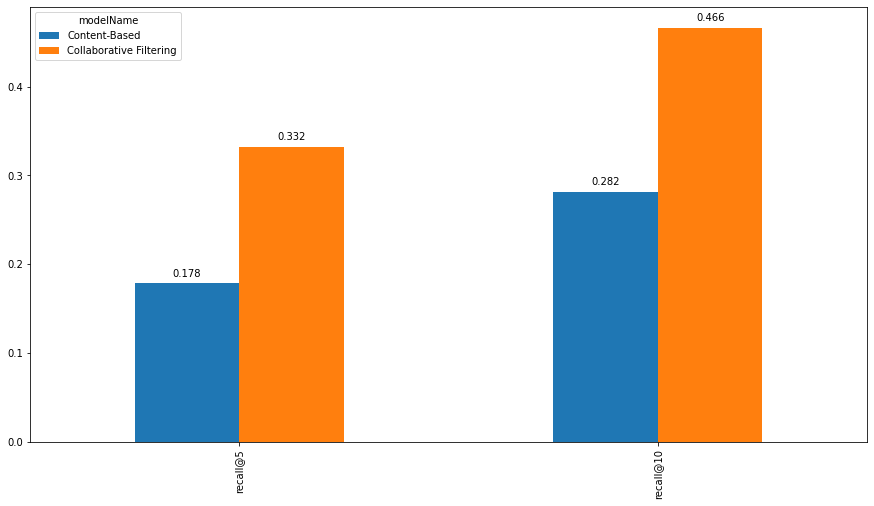

In [57]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

In [38]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions = interactions_test_indexed
    else:
        interactions = interactions_train_indexed
    return interactions.loc[person_id].merge(articles, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('weightage', ascending = False)[['weightage', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

In [50]:
inspect_interactions(-8845298781299428018, test_set=False).head(10)

,weightage,contentId,title,url,lang
72,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
84,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
12,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
9,3.954196,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
11,3.807355,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
5,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
14,3.584963,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
13,3.523562,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
37,3.459432,-5658245291907121574,Machine Learning and the VP Debate,https://medium.com/@srobtweets/machine-learnin...,en
8,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en


In [51]:
cf_recommender_model.recommend_items(-1479311724257856983, topn=10, verbose=True)

,recStrength,contentId,title,url,lang
0,0.263745,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
1,0.248555,4241385837165861843,Understanding the Twitter topic Tracker,https://unionmetrics.zendesk.com/hc/en-us/arti...,en
2,0.242852,430255078684584595,Google researchers teach AIs to see the import...,https://techcrunch.com/2016/06/28/google-resea...,en
3,0.240882,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
4,0.240548,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
5,0.239054,-3161714324304758767,Deep-learning algorithm predicts photos' memor...,http://news.mit.edu/2015/csail-deep-learning-a...,en
6,0.238120,8890720798209849691,Top 10 Intranet Trends of 2016,https://www.nngroup.com/articles/top-intranet-...,en
7,0.237345,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
8,0.236962,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
9,0.235328,882422233694040097,Infográfico: Algoritmos para Aprendizado de Má...,https://www.infoq.com/br/news/2016/07/infograf...,pt


In [52]:
content_based_recommender_model.recommend_items(-1479311724257856983, topn=10, verbose=True)

,recStrength,contentId,title,url,lang
0,0.639269,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
1,0.637502,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
2,0.601107,638282658987724754,Machine Learning for Designers,https://www.oreilly.com/learning/machine-learn...,en
3,0.549879,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
4,0.546483,-229081393244987789,Building AI Is Hard-So Facebook Is Building AI...,http://www.wired.com/2016/05/facebook-trying-c...,en
5,0.537449,-8068727428160395745,How real businesses are using machine learning,https://techcrunch.com/2016/03/19/how-real-bus...,en
6,0.530423,2220561310072186802,5 Skills You Need to Become a Machine Learning...,http://blog.udacity.com/2016/04/5-skills-you-n...,en
7,0.524373,54678605145828343,Is machine learning the next commodity?,http://readwrite.com/2016/04/18/machine-learni...,en
8,0.522402,-4571929941432664145,Machine Learning as a Service: How Data Scienc...,http://www.huffingtonpost.com/laura-dambrosio/...,en
9,0.511690,-9128652074338368262,Clarifying the uses of artificial intelligence...,http://techcrunch.com/2016/05/12/clarifying-th...,en
